In [2]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from utils import *

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'conv1d'
clean=True
csvpath = f"{TEMP_DATADIR}/df_{model_setting}_{data_setting}_{splitting}.csv"

## Model loading (Flynet)

In [3]:
traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_accuracy')
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=3)
model = modelconf.config
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

############ INPUT SHAPE:(5000, 1)


In [4]:
model.load_weights(f"{TEMP_DATADIR}/Flies_{data_setting}_{model_setting}_{splitting}.h5")

In [5]:
csvpath = f"{TEMP_DATADIR}/df_{model_setting}_{data_setting}_{splitting}.csv"
sub = pd.read_csv(csvpath, index_col=None)

In [6]:
missed = sub[sub.labels != sub.preds]
true_suz_pred_mel = sub[(sub.labels==1) & (sub.preds==0)]
true_mel_pred_mel = sub[(sub.labels==0) & (sub.preds==0)]
true_suz_pred_suz = sub[(sub.labels==1) & (sub.preds==1)]

In [7]:
def extract_features(fnames, labels, traincf):
    return model.predict(valid_generator(fnames, 
                                         labels,
                                         batch_size=traincf.batch_size,
                                         target_names=[0,1,2],
                                         setting=traincf.setting,
                                         preprocessing_train_stats=''),
                         steps=int(math.ceil(float(len(fnames))/float(traincf.batch_size))))

In [8]:
df = true_suz_pred_mel
pred_missed = extract_features(df.fnames.tolist(), df.labels.tolist(), traincf)

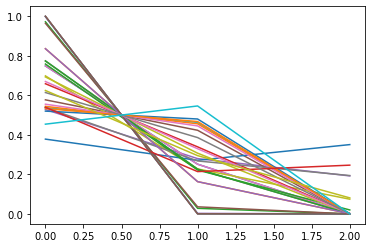

In [9]:
for i in range(30):
    rdm = np.random.randint(0,pred_missed.shape[0])
    plt.plot(pred_missed[rdm])

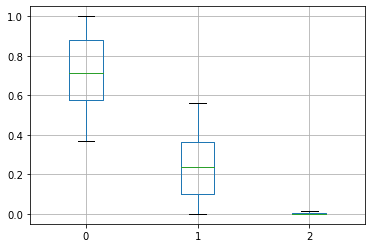

In [10]:
pd.DataFrame(np.round(pred_missed, decimals=4)).boxplot(showfliers=False)

### How it performs on specific data (Rodrigo's suzukii, Ludmilla's melanogaster)

In [11]:
rodsuz = DatasetConfiguration(names=['Rodrigo'])
rodsuz.select(name='Rodrigo', species=['D. suzukii'])
rodsuz.read()
if clean:
    rodsuz.clean()
rodsuz.df.labels.value_counts()    

Dataset - Rodrigo - exists: True


D. suzukii    866
Name: labels, dtype: int64

In [12]:
mebiosmel = DatasetConfiguration(names=['Melanogaster_RL'])
mebiosmel.select(name='Melanogaster_RL', species=['W'])
mebiosmel.read()
if clean:
    mebiosmel.clean()
mebiosmel.df.labels = mebiosmel.df.labels.apply(lambda x: x.replace("W", "D. melanogaster"))
mebiosmel.df.labels.value_counts()

Dataset - Melanogaster_RL - exists: True


D. melanogaster    524
Name: labels, dtype: int64

In [24]:
sub_rodsuz = sub[sub.fnames.isin(rodsuz.fnames.tolist())]
sub_rodsuz.preds.value_counts()

1    838
0     20
2      8
Name: preds, dtype: int64

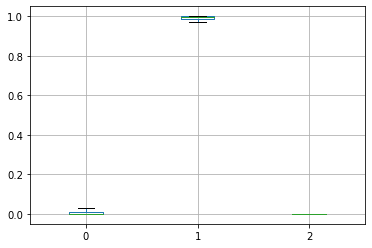

In [34]:
df = sub_rodsuz
pred_missed = extract_features(df.fnames.tolist(), df.labels.tolist(), traincf)
pd.DataFrame(np.round(pred_missed, decimals=4)).boxplot(showfliers=False)

In [25]:
sub_mebiosmel = sub[sub.fnames.isin(mebiosmel.fnames.tolist())]
sub_mebiosmel.preds.value_counts()

0    310
1    139
Name: preds, dtype: int64

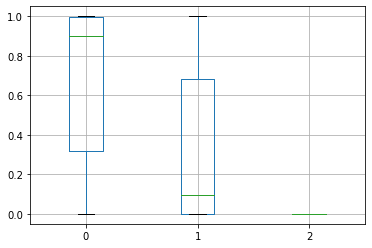

In [33]:
df = sub_mebiosmel
pred_missed = extract_features(df.fnames.tolist(), df.labels.tolist(), traincf)
pd.DataFrame(np.round(pred_missed, decimals=4)).boxplot(showfliers=False)